In [1]:
import os
import torch
import torch.nn as nn
import time
import csv
import pandas as pd
from torch.utils.data import DataLoader
import torch.nn.functional as func
from bs4 import BeautifulSoup
import numpy as np
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')

import re
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
from torch.optim import Adam
from tqdm.auto import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install datasets -q

In [4]:
!pip install transformers -q

In [5]:
import pandas as pd
from datasets import load_dataset

# squad_dataset = load_dataset("squad_v2")
squad_dataset = load_dataset("squad")
train_dataset = squad_dataset["train"]
df = pd.DataFrame(train_dataset)

In [6]:
# df[df['title']=='Beyoncé']
df.head()


,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...


In [7]:
# path = r"/content/gdrive/MyDrive/nlp dataset/dataset/train-v2.0.json"
# with open(path, 'r') as file:
#     data = json.load(file)

# print(data.keys())

In [8]:
# len(data['data']), len(data['data'][0]['paragraphs'])

In [9]:
# (data['data'][0].keys()), data['data'][0]['paragraphs'][1].keys()

In [10]:
# len(data['data'][0]['paragraphs'][1]['qas'])

In [11]:
# data['data'][0]['title']

In [12]:
# data['data'][0]['paragraphs'][0]['qas'][0]

In [13]:
# data['data'][0]

In [14]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import torch.nn as nn

In [15]:
class SoftEmbedding(nn.Module):
  def __init__(self, wte, n_tokens):
      super(SoftEmbedding, self).__init__()
      self.wte = wte
      self.n_tokens = n_tokens
      self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte, n_tokens))

  def initialize_embedding(self, wte, n_token):
      return self.wte.weight[:n_tokens].clone().detach()

  def forward(self, tokens):
      input_embedding = self.wte(tokens[:, self.n_tokens:])
      learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
      return torch.cat([learned_embedding, input_embedding], 1)

In [16]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [17]:
n_tokens=2

In [18]:
s_wte = SoftEmbedding(model.get_input_embeddings(),
                      n_tokens=n_tokens)

In [19]:
print(s_wte)

SoftEmbedding(
  (wte): Embedding(50257, 768)
)


In [20]:
model.set_input_embeddings(s_wte)

In [21]:
print(model.get_input_embeddings())


SoftEmbedding(
  (wte): Embedding(50257, 768)
)


In [22]:
inputs = tokenizer("May the force be", return_tensors="pt")

# need to pad attention_mask and input_ids to be full seq_len + n_learned_tokens
# even though it does not matter what you pad input_ids with, it's just to make HF happy
inputs['input_ids'] = torch.cat([torch.full((1,n_tokens), 50256), inputs['input_ids']], 1)
inputs['attention_mask'] = torch.cat([torch.full((1,n_tokens), 1), inputs['attention_mask']], 1)

outputs = model(**inputs)

In [23]:
print(outputs["logits"].shape)


torch.Size([1, 6, 50257])


In [24]:
data = {}
maxi_context = 0
for sent in df['context']:
    maxi_context = max(maxi_context, len(sent.split()))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_context)

653


In [25]:
len(df)

87599

In [26]:
# data = {}
# maxi_text = 0

# for i, sent in enumerate(df['answers']):
#     print(len(sent['text']), sent['text'])
#     text_length = len(sent['text'][0].split()) if len(sent['text']) > 0 else 0
#     maxi_text = max(maxi_text, text_length)

#     if text_length in data:
#         data[text_length] += 1
#     else:
#         data[text_length] = 1

# print("Maximum text length:", maxi_text)
# print("Length distribution:", data)


data = {}
maxi_text = 0
for i, sent in enumerate(df['answers']):
    maxi_text = max(maxi_text, len(sent['text'][0].split()))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_text)

43


In [27]:
df.columns

Index(['id', 'title', 'context', 'question', 'answers'], dtype='object')

In [28]:
df.head()

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...


In [29]:
df['text'] = df['answers'].apply(lambda x: x['text'][0])

# Drop the original column if needed
# df = df.drop('answers', axis=1)

In [30]:
df.head()

,id,title,context,question,answers,text
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ...",Saint Bernadette Soubirous
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe...",a copper statue of Christ
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'...",the Main Building
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...,a Marian place of prayer and reflection
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...,a golden statue of the Virgin Mary


In [31]:
df_new = df[['question', 'text']]

In [32]:
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config, AdamW
from torch.nn import Embedding
from datasets import load_dataset
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

tokenizer.add_special_tokens({"pad_token": "<pad>",
                              "bos_token": "<sos>",
                              "eos_token": "<eos>"
                             })
model.config.pad_token_id = tokenizer.pad_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

tokenizer.add_tokens(["<extract>"])
model.resize_token_embeddings(len(tokenizer))

n_tokens = 1

s_wte = SoftEmbedding(model.get_input_embeddings(), n_tokens=n_tokens)
model.set_input_embeddings(s_wte)

if torch.cuda.is_available():
    model = model.cuda()

In [34]:
# Fine-tuning parameters
batch_size = 4
epochs = 5
learning_rate = 1e-5
gradient_clip_value = 1.0

In [35]:
len(df_new)

87599

In [48]:
class Squad(Dataset):
  def __init__(self, squad, tokenizer):
    self.data = squad
    self.question = self.data['question']
    self.text = self.data['text']
    self.X = []

    for question, text in zip(self.question, self.text):
        self.X.append("<sos> " + question + " <extract> " + text + " <eos>")

    self.encode = tokenizer(self.X, max_length=100, truncation=True, padding="max_length", return_tensors="pt")
    # self.encode = torch.cat([torch.full((1,n_tokens), 50261), self.encode], 1)
    self.attention_mask = self.encode['attention_mask']
    self.input_ids = self.encode['input_ids']

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return (self.input_ids[idx], self.attention_mask[idx])

In [49]:
dataset = Squad(df_new[:10000], tokenizer)
dataloader = DataLoader(dataset, batch_size=1)

In [50]:
batch_size = 1

dataset_val = Squad(df[10000:11000], tokenizer)
dataloader_val = DataLoader(dataset_val, batch_size=1)


In [51]:
for batch in dataloader:
    print(len(batch[0][0]), batch[0][0])
    print(len(batch[1][0]), torch.sum(batch[1][0]), batch[1][0])
    break

100 tensor([50258,  1675,  4150,   750,   262,  5283,  5335,  7910,  1656,   287,
         1248,  3365,   287,   406,   454,  8906,  4881,    30,   220, 50260,
         9281,  6206,   324,  5857,   311, 12944,   343,   516,   220, 50259,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257])
100 tensor(30) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [52]:
optim = Adam(model.parameters(), lr=1e-3)
device = 'cuda'

In [53]:
parameters = list(model.parameters())
for x in parameters[1:]:
    x.requires_grad = False

In [55]:
epochs = 1
total_loss = 0
num_batches = 0
losses = []
rouges = []
optim = Adam(model.parameters(), lr=1e-1)

model = model.to('cuda')
for epoch in range(epochs):
    for ques, ans in tqdm(dataloader):
        # print(ques.shape)
        # print(ans.shape)
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        # print(loss)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        num_batches += 1
        losses.append(loss.item() / batch_size)
    avg_loss = total_loss / num_batches
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')
    if avg_loss <= 0.155:
        model.save_pretrained('gpt2_squad')


    val_loss = 0
    num_batches = 0
    for ques, ans in tqdm(dataloader_val):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        optim.step()

        val_loss += loss.item()
        num_batches += 1
        # losses.append(loss.item() / batch_size)
    avg_loss = val_loss / num_batches
    print(f'Epoch: {epoch+1}, VAL Loss: {avg_loss:.4f}')


100%|██████████| 10000/10000 [06:23<00:00, 26.10it/s]


Epoch: 1, Loss: 19.3316


100%|██████████| 1000/1000 [00:22<00:00, 44.96it/s]

Epoch: 1, VAL Loss: 19.2178


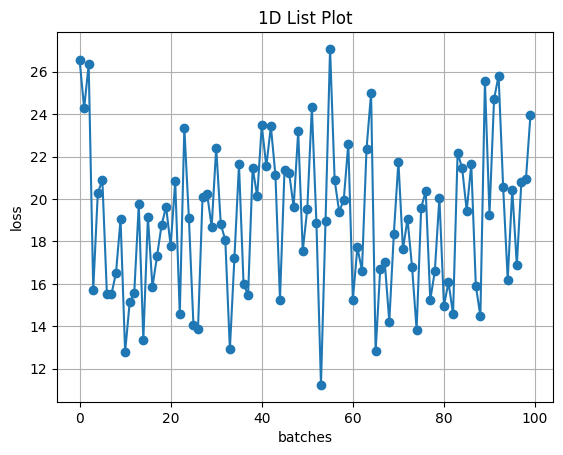

In [56]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# result = [10, 15, 20, 18, 25]

# Plot the data
plt.plot(losses[::100], marker='o')
plt.xlabel('batches')
plt.ylabel('loss')
plt.title('1D List Plot')
plt.grid(True)
plt.show()


Different Hyperparameter

In [64]:
epochs = 2
total_loss = 0
num_batches = 0
losses = []
rouges = []
optim = Adam(model.parameters(), lr=1e-1)

model = model.to('cuda')
for epoch in range(epochs):
    for ques, ans in tqdm(dataloader):
        # print(ques.shape)
        # print(ans.shape)
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        # print(loss)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        num_batches += 1
        losses.append(loss.item() / batch_size)
    avg_loss = total_loss / num_batches
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')
    if avg_loss <= 0.155:
        model.save_pretrained('gpt2_squad')


    val_loss = 0
    num_batches = 0
    for ques, ans in tqdm(dataloader_val):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        optim.step()

        val_loss += loss.item()
        num_batches += 1
        # losses.append(loss.item() / batch_size)
    avg_loss = val_loss / num_batches
    print(f'Epoch: {epoch+1}, VAL Loss: {avg_loss:.4f}')


100%|██████████| 10000/10000 [06:20<00:00, 26.27it/s]


Epoch: 1, Loss: 19.3316


100%|██████████| 1000/1000 [00:22<00:00, 45.44it/s]


Epoch: 1, VAL Loss: 19.2178


100%|██████████| 10000/10000 [06:02<00:00, 27.56it/s]


Epoch: 2, Loss: 35.1484


100%|██████████| 1000/1000 [00:22<00:00, 44.88it/s]

Epoch: 2, VAL Loss: 19.2178


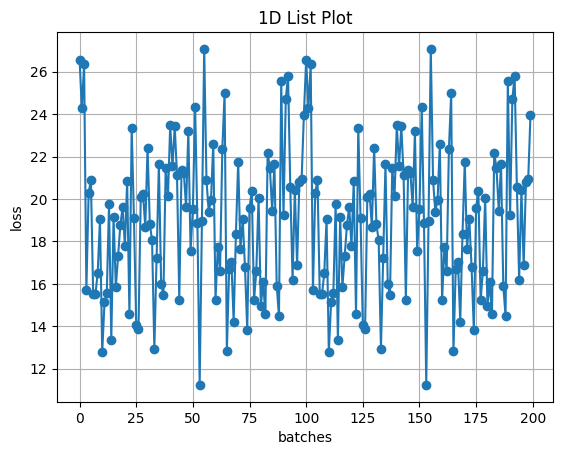

In [65]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# result = [10, 15, 20, 18, 25]

# Plot the data
plt.plot(losses[::100], marker='o')
plt.xlabel('batches')
plt.ylabel('loss')
plt.title('1D List Plot')
plt.grid(True)
plt.show()


In [66]:
trained_parameter = parameters[0]


In [67]:
model.save_pretrained("/content/gdrive/MyDrive/nlp dataset/gpt2_squad.pth")


In [73]:
no_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(no_of_parameters)

768


In [74]:
trained_parameter


Parameter containing:
tensor([[-2.4421e-01, -6.1015e-01, -8.3104e-01, -9.4396e-01, -1.2955e-01,
         -5.9097e-01, -6.3230e-01, -6.8485e-02,  7.4566e-01, -8.2997e-03,
         -5.8487e-01,  3.7118e-01, -4.9086e-01, -1.9561e+00,  2.5578e+00,
         -5.9271e-01,  1.9535e+00,  1.0676e+00, -1.8577e+00,  1.2755e+00,
         -9.6459e-01, -1.1312e+00, -4.5587e-01, -1.2911e+00,  4.6091e-01,
         -2.0592e+00,  5.7648e-01,  5.5502e-01,  3.2490e-01, -3.1656e-01,
         -2.8994e-01, -9.1055e-02,  4.4291e-01, -7.3945e-02,  1.4437e+00,
          4.2277e-01,  2.6976e+00,  4.3236e-01,  5.4038e-01, -1.5451e+00,
         -1.2621e+00, -3.2218e-01,  6.8192e-01,  1.1043e+00, -3.2679e-01,
         -8.8474e-01,  2.0789e+00,  1.0385e+00,  1.5869e+00,  3.2641e-01,
          2.8286e-01, -1.4492e+00, -1.5633e+00, -2.0283e+00,  1.0941e+00,
         -1.8569e+00,  7.6010e-01,  1.1509e+00, -8.3699e-01,  5.3140e-01,
         -4.2970e-01,  5.6371e-01,  1.0105e+00,  2.0950e-01,  8.7402e-01,
         -5.5053

In [75]:
def inference(input_text, model):
    model = model.to('cpu')
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), input_ids], 1)
    # print(input_ids)
    output_ids = model.generate(input_ids, max_length=200, num_beams=5, no_repeat_ngram_size=2, top_k=50)
    output_ids = output_ids
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text

In [76]:
from nltk.translate.bleu_score import sentence_bleu

def find_bleu(reference_tokens, candidate_tokens):
    print("required : ", reference_tokens)
    print("Predicted : ", candidate_tokens)
    mini = min(len(candidate_tokens.split()), len(reference_tokens.split()))
    reference_tokens = [token.lower() for token in reference_tokens.split()]
    candidate_tokens = [token.lower() for token in candidate_tokens.split()]

    # Calculate BLEU score
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    # Print the BLEU score
    print("BLEU Score:", bleu_score)


In [82]:
for i in range(110,134):
    # print("question :", df_new.loc[i]['question'])
    find_bleu(df_new.loc[i]['text'], inference(df_new.loc[i]['question'], model))

required :  Laetare Medal
Predicted :  Irvin Abell was given what award by Notre Dame?
BLEU Score: 0
required :  1883
Predicted :  Which year was the Laetare Medal first given out at Notre Dame?
BLEU Score: 0
required :  God
Predicted :  For whos glory did Father O'Hara believed that the Notre Dame football team played?
BLEU Score: 0
required :  more than half
Predicted :  Around the time that Rev. Cavanaugh became president of Notre Dame by how much did the undergrad student body of Notre Dame increase?
BLEU Score: 0
required :  Lobund Institute for Animal Studies
Predicted :  Which institute involving animal life did Cavanaugh create at Notre Dame?
BLEU Score: 1.1896457329133973e-231
required :  Hall of Liberal Arts
Predicted :  What is O'Shaughnessy Hall of Notre Dame formerly known as?
BLEU Score: 5.7592918561109494e-155
required :  Rev. John J. Cavanaugh, C.S.C.
Predicted :  Which president did Notre Dame have in 1947?
BLEU Score: 0
required :  Medieval Institute
Predicted :  Outs